# Лабораторные работы II - Графы наносят ответный удар

В этой лабе вам предстоит сделать реальное тестовое задание в исследовательскую лабораторию.<br>
Ваша задача будет найти около-оптимальное разбиение вершин графа на N сообществ (кластеров). Решать её вы будете, пытаясь оптимизировать модулярность. Подробнее о метрике читаем в <href>https://en.wikipedia.org/wiki/Modularity_(networks)</href>


## Установим либы, если их нет
<href>https://pytorch.org/get-started/locally/</href><br>
P.S. В этой лабе не нужно сильных вычислительных мощностей, поэтому можно ставить CPU версию торча. Но если у вашего компа есть видеокарта с поддержкой CUDA и вы планируете делать лабы локально, сразу ставьте cuda-версию. В крайнем случае google colab вам в помощь.

In [1]:
%pip install git+https://github.com/Casyfill/pyCombo.git

  Cloning https://github.com/Casyfill/pyCombo.git to c:\users\nikol\appdata\local\temp\pip-req-build-9x1kyydl
  Resolved https://github.com/Casyfill/pyCombo.git to commit f8bddca91e267f15930f6bd53b5eafcad6d82845
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/Casyfill/pyCombo.git 'C:\Users\nikol\AppData\Local\Temp\pip-req-build-9x1kyydl'
  Running command git submodule update --init --recursive -q


## Импортим либы

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import networkx as nx
from networkx.linalg.graphmatrix import adjacency_matrix

## Обучаем(ся)

Считаем модулярность в матричном виде: $$Q=\frac{1}{2m}Tr(S^{T}BS),$$
где $m$ - количество ребер в графе, $B$ - матрица модулярности.
<br>$S_{vr}$ определим равной 1, если вершина $v$ принадлежит сообществу $r$.<br>
Shapes: $S$ - [num_nodes, num_communities], $T$ - [num_nodes, num_nodes]<br>
Tr - trace<br><br>
Ваша задача найти около-оптимальную матрицу $S$, при которой для данного графа значение модулярности будет максимальным

In [3]:
class GraphCommunityHandler(nn.Module):
    def __init__(self, G: nx.Graph, communities_num: int = 3):
        super().__init__()
        self.G = G
        self.communities_num = communities_num
        
        # Посчитайте матрицу модулярности
        self.modularity_matrix: torch.FloatTensor = ...
        
        # Это матрица S, которую вы будете обучать. Инициализируйте ее равномерно значениями от 0 до 1.
        # Подумайте во что обернуть тензор, чтобы потом легко отправить параметры в оптимайзер.
        self.partition = ...

    def get_approx_partition(self) -> torch.FloatTensor:
        # Возвращает приближенное разбиение. Пример для одной вершины: [0.2, 0.7, 0.1] в случае 3 сообществ. 
        # Для итогового разбиения мы берем сообщество с наибольшим значением.
        partition = F.softmax(self.partition, dim=-1)
        return partition
    
    def get_partition(self) -> torch.LongTensor:
        # Возвращает итоговое разбиение. Вершины однозначно разбиты по классам 
        return F.one_hot(torch.argmax(self.get_approx_partition(), dim=-1),
                         num_classes=self.communities_num)
        
    def calculate_modularity(self, partition: torch.FloatTensor):
        # Посчитайте модулярность
        pass


## Visualize partition

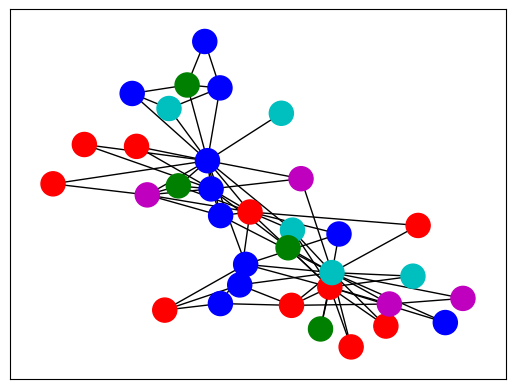

In [9]:
def visualize_partition(graph, partition):
    colors = np.array(list(mcolors.BASE_COLORS.values()))
    node_colors = colors[np.argmax(partition, axis=-1)]
    nx.draw_networkx(graph, with_labels=False, node_color=node_colors)

    
community_handler = GraphCommunityHandler(nx.karate_club_graph(), 5)
partition = community_handler.get_partition()
visualize_partition(nx.karate_club_graph(), partition)

In [ ]:
def find_optimal_partition(graph, num_iters, max_communities):
    community_splitter = GraphCommunityHandler(graph, max_communities)
    # Передайте тензоры, которые должны обучаться, в оптимайзер
    optimizer = optim.Adam(..., lr=0.001)
    
    max_modularity = -1
    final_partition = None
    score_no_change_cnt = 0
    
    for iter in range(num_iters):
        optimizer.zero_grad()
        # Считаем модулярность для приблизительного разбиения и пробуем оптимизировать его
        approx_modularity = ...
            
        # Градиент идёт в сторону уменьшения значения функции. 
        # Подумайте что, тогда нужно оптимизировать
        to_optimize = ...
        
        # Вызываем обратное распространение ошибки
        to_optimize.backward()
        
        # Обновляем веса
        optimizer.step()
        
        
        if iter % 10 == 0:
            # Если значение модулярности не улучшается больше 10 шагов, останавливаем обучение
            
            # Считаем модулярность для итогового разбиения
            modularity = ...
            print(f'Iteration {iter}: modularity value - {modularity}')
            if max_modularity < modularity:
                max_modularity = modularity
                final_partition = ...
                score_no_change_cnt = 0
            else:
                score_no_change_cnt += 1
            if score_no_change_cnt > 10:
                break
                
    return max_modularity, final_partition.numpy()


modularity, partition = find_optimal_partition(nx.karate_club_graph(), 500, 2)

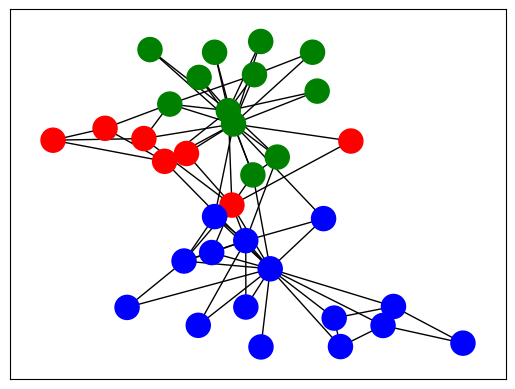

In [11]:
visualize_partition(nx.karate_club_graph(), partition)

### Позапускайте процесс несколько раз и сравните результаты. Насколько стабильно вы получаете лучший ответ? Если не стабильно, то с чем это связано?
Добейтесь получения стабильно хорошего разбиения (тут велосипеды придумывать не надо, используйте простейшие идеи)

## Compare your results with SOTA

In [ ]:
import pycombo

g = nx.karate_club_graph()

def test_on_graph(graph):
    print("Combo: %f" % (pycombo.execute(graph, return_modularity=True, max_communities = 2)[1]))
    print("My approach: %f" % (...))
    print('-' * 50)

test_on_graph(nx.karate_club_graph())
test_on_graph(nx.les_miserables_graph())
test_on_graph(nx.davis_southern_women_graph())
test_on_graph(nx.florentine_families_graph())